<a href="https://colab.research.google.com/github/punnoose-1620/masters-thesis-sensor-data/blob/main/Intent_Data_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Installs

In [1]:
!pip install tqdm
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn
!pip install sentence-transformers scikit-learn

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import pandas as pd
import random
import json
import re

# Data Generation and Cross Verification

## Declare Data Parameters and Limits

### 1. Define Brand-Model Mappings (Verified for 2024-2026)

In [3]:
# Structure: {Brand: {Model: [Year Range]}}
AUTOMOTIVE_MAP = {
    "Volvo": {
        "XC90": list(range(2015, 2026)),
        "XC60": list(range(2017, 2026)),
        "EX90": [2024, 2025, 2026],
        "EX30": [2023, 2024, 2025, 2026],
        "S90": list(range(2016, 2026)),
        "V60 Recharge": [2021, 2022, 2023, 2024, 2025],
        "EM90": [2024, 2025]
    },
    "Polestar": {
        "Polestar 2": [2020, 2021, 2022, 2023, 2024, 2025],
        "Polestar 3": [2023, 2024, 2025],
        "Polestar 4": [2024, 2025],
        "Polestar 5": [2025, 2026]
    },
    "Lynk & Co": {
        "01": list(range(2017, 2026)),
        "03 TCR": [2019, 2020, 2021, 2022, 2023, 2024, 2025],
        "05": [2020, 2021, 2022, 2023, 2024, 2025],
        "08 EM-P": [2023, 2024, 2025],
        "09 Ultra": [2021, 2022, 2023, 2024, 2025],
        "Z10": [2024, 2025]
    },
    "Zeekr": {
        "001": [2021, 2022, 2023, 2024, 2025],
        "007": [2023, 2024, 2025],
        "009": [2022, 2023, 2024, 2025],
        "X": [2023, 2024, 2025],
        "7X": [2024, 2025],
        "Mix": [2024, 2025]
    },
    "Jiyue": {
        "01": [2023, 2024, 2025],
        "07": [2024, 2025]
    },
    "Lotus": {
        "Eletre": [2023, 2024, 2025],
        "Emira": [2022, 2023, 2024, 2025],
        "Emeya": [2024, 2025],
        "Evija": [2020, 2021, 2022, 2023, 2024, 2025]
    },
    "Geely Auto": {
        "Starray": [2022, 2023, 2024, 2025],
        "Coolray": [2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025],
        "Geometry E": [2022, 2023, 2024, 2025],
        "Galaxy L7": [2023, 2024, 2025],
        "Panda Mini": [2023, 2024, 2025],
        "Emigrant": [2021, 2022, 2023, 2024, 2025]
    }
}

### 2. Define Technical Sensor/Data Categories

In [4]:
# Replace SENSORS and TOOLS with these to capture regional terminology
SENSORS = [
    "LiDAR", "Lidar", "LIDAR", # Casing variations
    "Tyre Pressure", "Tire Pressure", "TPMS",
    "Boot latch sensor", "Trunk sensor",
    "High Voltage battery", "HV battery", "Traction battery",
    "NVH", "Noise and Vibration", "Acoustics",
    "Bonnet sensor", "Hood sensor",
    "ADAS Camera", "Vision system", "Autonomous sensor",
    "CAN-FD", "CANBUS", "Control Network"
]

SPECIAL_TOOLS = [
    "Kistler Wheels", "Oxford RT3000", "Micro-epsilon",
    "HEAD acoustics", "Roof-mounted rig", "OBD-II logger",
    "CANoe hardware", "Data logger unit"
]

FORMATS = ["MDF4", "Parquet", "CSV", "JSON", "HDF5"]

### 3. Define Intent Templates (Mapped to your 20 Questions)

In [5]:
VERBOSE_TEMPLATES = {
    "data_definition": [
        # Original 16 + 25 New
        "I am looking into the signal processing for the {brand} {model} project. I see multiple streams in the data lake, specifically for {sensor}. What types of data are available here and why do we prefer {format}?",
        "We are drafting the technical documentation for the {year} {model}. For the {sensor} section, can you explain the context/meaning of this data and how it relates to vehicle performance?",
        "Reviewing the signal manifest for {brand} {year}. There is some confusion in the lab about {sensor} units. What is the actual definition and data type we are pulling from the gateway?",
        "Regarding the {model} mid-cycle refresh: we have new {sensor} nodes. I need a breakdown of the available signals and the reason {format} was chosen for this specific logger.",
        "The perception team is asking about the raw output of {sensor} on the {brand} {model}. Can you define the metadata fields and tell me what information is actually captured?",
        "I'm comparing the {sensor} bus logs between different {brand} trims. For the {model}, what is the specific technical context of this signal compared to standard ADAS logs?",
        "During the sensor fusion workshop for {model}, we discussed {sensor}. I need to know the bit depth and frequency available in our current {format} exports.",
        "Checking the cloud schema for {year} {brand} {model}. I see an entry for {sensor} but no clear description. What does this represent in the vehicle control module?",
        "The {sensor} data on the {model} doesn't match the legacy documentation. Can you provide the current data definition and verify if it's stored in {format}?",
        "We are onboarding a new supplier for {brand} {sensor} hardware. For the {model} integration, what data structures are we expecting to see in the daily logs?",
        "I need a deep dive into {sensor} for the {year} {model} project. Is this raw voltage, a processed value, or a filtered state? Also, why use {format} instead of CSV?",
        "The telemetry dashboard for {brand} is showing {sensor} but the tooltip is empty. What is the functional description for this sensor on the {model} platform?",
        "Preparing a report for the {model} safety committee. I need a clear definition of what {sensor} measures and the standard data formats available for download.",
        "In the latest software sprint for {brand} {year}, we changed the {sensor} logging logic. What information is now available for {model} users in the data portal?",
        "I'm looking at the CAN-FD mapping for {model}. There is a signal labeled {sensor}. Can you explain its context and why we are capturing it in {format}?",
        "For the {brand} {model} V-cycle validation, we need to clarify our {sensor} data types. What is the full definition of this stream in our current database?",
        "The {brand} internal wiki is outdated regarding {model} software. I need to confirm the {sensor} technical specs—what kind of data is this and why is the default {format}?",
        "Field engineers in China are reporting a new signal alias for {sensor} on the {year} {model}. Can you define what this signal represents in our data architecture?",
        "We are seeing {sensor} appear in the high-level CAN bus on {model}. I need the data dictionary definition for this and the reason for the {format} encapsulation.",
        "A supply chain change in {brand} {year} resulted in a new firmware version for the {sensor}. What data types are supported now for the {model} platform?",
        "During the cross-functional meeting for {model}, the question of {sensor} fidelity came up. What is the data definition and are we still using {format}?",
        "I am trying to map the {sensor} to our internal PowerBI dashboard for {brand}. What is the context of this data and what {format} should I expect?",
        "The {model} hardware-in-the-loop tests are failing because of a {sensor} mismatch. What is the official definition of this data in the current {brand} spec?",
        "We need to clarify the {sensor} telemetry for the {year} {model} global release. What is the data type and does it vary between {brand} regions?",
        "I'm reviewing the {sensor} extraction script for {model}. What is the technical context here and why was the {format} standard applied?",
        "The {brand} cloud team needs the schema for {sensor} on the {model}. What data types are available and what is the functional use case?",
        "Following up on Jira ticket #4402: the {sensor} on {year} {model} is missing a description. What does this telemetry actually track?",
        "We are optimizing the database for the {model}. Regarding the {sensor} table, what is the data definition and why are we storing it as {format}?",
        "The {brand} {model} team is asking for a deep dive into {sensor}. What is the signal context and the reason for choosing {format} as the output?",
        "I am looking at the legacy logs for {year} {brand} {model}. The {sensor} data looks unfamiliar—can you define the context and format used here?",
        "For the {model} thermal management study, we are using {sensor}. What is the data definition and how is it structured in the {format} file?",
        "The {brand} {model} diagnostic tool is flagging {sensor} metadata. What is the technical definition and what are the standard data types?",
        "I need to verify the {sensor} signal context for the {year} {model} update. What is being measured and why is the export set to {format}?",
        "The {model} electrical engineering group is asking about {sensor} latency. Before we test, what is the data definition and current format?",
        "I'm seeing {sensor} logs for {brand} {model} that don't match our API. What is the intended data definition and what format is currently supported?",
        "For the {year} {model} software validation, we need to document the {sensor}. What is the signal context and the technical data type?",
        "The {brand} {model} integration team is confused about the {sensor} bit-masking. What is the data definition and how is it saved in {format}?",
        "I am performing a sanity check on {sensor} for the {model}. Can you provide the data definition and the reason for the current {format}?",
        "The {year} {brand} {model} release notes mention new {sensor} capabilities. What data types are now available and what is the signal context?",
        "We are refactoring the {model} ingestion pipeline for {sensor}. What is the data definition and why do we continue to use {format}?",
        "The {brand} {model} team needs the technical specs for {sensor}. What is the definition and the required data format for this project?",
        "I am reviewing the signal list for {year} {model}. I found {sensor}—what is the context for this and why is it categorized under {format}?"
    ],
    "temporal_stats": [
        # Original 16 + 25 New
        "There seems to be a gap in the telemetry logs for the {model} fleet during the Q3 testing phase. When did we start and stop collecting {sensor} data for this specific model year?",
        "I'm trying to sync the video feeds with the {sensor} logs for {brand}. When was this data last updated, and was the collection stopped for a specific reason regarding hardware?",
        "We are looking for historical trends in {sensor} performance for the {year} {brand} {model}. What is the earliest available timestamp we have for this sensor?",
        "The {model} field test was supposed to run through December. Can you check the collection window for {sensor} and tell me if we have any data from the final week?",
        "I noticed the {sensor} stream for {brand} {model} went dark recently. What was the last recorded date, and when did the initial collection start for this VIN range?",
        "For the {year} {model} durability report, I need the total duration of {sensor} collection. When was the first log created and when did we officially stop monitoring?",
        "Is the {sensor} data for the {brand} {model} still being actively ingested, or did we decommission that pipeline after the last firmware update?",
        "I need to verify the sample history of {sensor} on {model}. Since what date have we been archiving this, and is there a scheduled end-to-collection date?",
        "The project lead is asking for the 'Golden Run' of {sensor} for the {brand} {year}. When was the most recent update to this specific dataset for {model}?",
        "We are seeing a lack of {sensor} data for the {model} in early 2024. Was the collection paused, and what are the exact start/stop dates for that period?",
        "Checking the lifecycle of {sensor} data for {brand}. For the {model} development phase, what is the temporal range of the available logs in the archive?",
        "Did we begin recording {sensor} for the {year} {model} during the prototype phase or only after production start? I need the exact start date.",
        "I'm investigating a late-stage bug in the {brand} {model}. I need to know if we have {sensor} logs going back to the summer heat tests in Spain.",
        "The {sensor} collection for {model} appears to be inconsistent. Can you provide a timeline of when the data was active versus when it was offline?",
        "For the {year} {brand} {model} environmental validation, I need to know the total history of {sensor} data. When did the first record appear in the system?",
        "What is the current status of the {sensor} data pipeline for {model}? I need the last sync time and the date we started the fleet-wide roll-out.",
        "The {brand} {model} logs for {sensor} seem to stop abruptly in the winter dataset. What was the exact date and time the collection was terminated?",
        "I am looking for the lifecycle data of {sensor} for {year} {model}. Can you tell me when we first enabled this on the test fleet and when it was shut down?",
        "Following up on the {model} decommission: did we stop recording {sensor} before or after the final firmware flash? I need the temporal stats.",
        "We need to audit the {sensor} availability for {brand} {model}. Since what year have we been tracking this and when was the last successful upload?",
        "The {year} {brand} {model} project has a gap in {sensor} logs from May to June. When did the collection actually restart and what is the stop date?",
        "I'm trying to build a timeline for {model} sensor degradation. When did we start the first {sensor} collection cycle for {brand}?",
        "Regarding the {model} beta phase: was {sensor} collected during the whole period? I need the start and stop timestamps for the archive.",
        "The {brand} {model} data warehouse is showing empty rows for {sensor} in late {year}. When was the collection window officially closed?",
        "I am comparing {sensor} data across several {brand} models. For the {model}, what are the start/stop dates for the active collection phase?",
        "We are missing the {sensor} end-of-life stats for the {year} {model}. When did we stop the logging and what was the reason for the cutoff?",
        "I need the temporal range for {sensor} on the {brand} {model}. Is there a date when we significantly changed the collection frequency?",
        "Checking the {model} validation logs: when was the very first {sensor} packet received for the {year} build?",
        "The {brand} {model} team needs the history of {sensor} collection. Was it continuous since {year}, or were there specific stop/start periods?",
        "I'm investigating the {sensor} uptime for {model}. When did we start the pilot program and when was the last time the data was refreshed?",
        "For the {year} {model} fleet, when was the {sensor} collection officially discontinued? I need this for the legacy report.",
        "We are looking for {sensor} logs from the {brand} {model} prototype phase. What is the start date for that specific dataset?",
        "The {model} {sensor} stream was supposedly active until last Friday. Can you verify the last update time and the initial start date?",
        "I need the full temporal audit for {sensor} on {brand} {model}. When did the first test vehicle start uploading and when did the program end?",
        "Regarding the {year} {model} recall analysis: when did we stop collecting {sensor} for the affected VINs?",
        "I'm trying to pull {sensor} data for the {brand} {model} from two years ago. When did that specific collection run start and end?",
        "The {model} {sensor} collection seems to have a hard stop in our database. When was that date and when did the collection originally begin?",
        "I need to know the 'active days' for {sensor} on the {year} {model}. What are the start and stop dates for the entire testing block?",
        "We are reviewing the {brand} {model} telemetry history. Since when have we been recording {sensor} and is it still active today?",
        "For the {model} durability cycle, I need the precise start/stop times for the {sensor} logging during the 24-hour run.",
        "The {year} {brand} {model} data is fragmented. Can you provide the start and stop dates for the {sensor} collection sessions?",
        "Checking the {model} project milestones: when was {sensor} collection first initiated for the {brand} test mules?"
    ],
    "statistical_query": [
        # Original 16 + 25 New
        "System report indicates fluctuations in {model} telemetry. I've reviewed the raw logs but need a high-level summary. What is the average {sensor} value recorded during the high-speed track session?",
        "We are investigating the efficiency of the {brand} {year} powertrain. To finalize the report, please calculate the mean {sensor} across the current test fleet.",
        "I'm seeing high thermal loads on the {model} during hill climbs. Can you provide the peak {sensor} readings for the last five test runs?",
        "For the {brand} {model} benchmark study, I need the standard deviation and average for {sensor} across all units running software version 2.1.",
        "The chassis team is concerned about vibration on the {year} {model}. What is the maximum recorded value for {sensor} during the cobblestone road test?",
        "We need to calibrate the {sensor} for the {model}. What is the typical operating range and the average value we see during urban driving cycles?",
        "I'm analyzing the energy consumption of the {brand} {model}. Give me the total sum and the average {sensor} output for the long-range trip logs.",
        "During the {year} {model} track day, the {sensor} hit some extreme values. What were the absolute peaks and how do they compare to the fleet average?",
        "I need a statistical profile for {sensor} on the {brand} {model}. What are the 95th percentile values for this signal during winter testing?",
        "The {model} torque delivery seems uneven. Can you pull the average {sensor} readings and tell me the highest value reached during the 0-100 sprint?",
        "We are looking for a baseline for {sensor} in the {brand} {year}. What is the most common or frequent value recorded during idle states for {model}?",
        "For the {model} aerodynamics report, I need the mean {sensor} pressure at high speeds. Please provide the average and the max/min bounds.",
        "I'm reviewing the {sensor} logs for {brand} {model}. The data looks noisy; can you provide the median and the average to help me filter it?",
        "What is the highest temperature or value recorded by {sensor} on the {model} during the Death Valley testing phase?",
        "I need to summarize the {sensor} performance for the {year} {brand} fleet. What is the average value per 100km driven for {model}?",
        "The {model} power electronics team needs the peak {sensor} current. What was the maximum value observed during the fast-charging sessions?",
        "I am looking at the {sensor} distribution for the {year} {model}. What is the average reading during the urban stop-and-go cycle?",
        "The {brand} {model} team is reporting strange {sensor} data. Can you provide the mean and the standard deviation for the last batch of logs?",
        "We are benchmarking the {model} against the {year} specs. What are the highest and lowest {sensor} values recorded during the endurance run?",
        "I need to know the average {sensor} output for {model} vehicles in the China market compared to the global {brand} average.",
        "Regarding the {year} {model} brake test: what were the peak {sensor} values and the average deceleration force recorded?",
        "I'm calculating the duty cycle for {sensor} on the {brand} {model}. What is the mean value and the frequency of the highest peaks?",
        "The {model} project manager needs a stats summary for {sensor}. What is the average value and the total variance for the {year} fleet?",
        "During the {brand} {model} cold start tests, what was the average {sensor} reading in the first 60 seconds?",
        "I am looking for the 'normal' range of {sensor} for the {year} {model}. What is the average and the 2nd standard deviation?",
        "The {model} steering logs show a lot of variation. What is the mean {sensor} value and the absolute peak for the steering rack?",
        "We are optimizing the {brand} {model} cooling loop. What is the average {sensor} temperature and the max peak during the stress test?",
        "I need a breakdown of {sensor} stats for the {year} {model}. What is the mean, max, and min for the city driving dataset?",
        "The {brand} {model} suspension team needs the peak {sensor} loads. What was the average and the highest spike during the gravel test?",
        "I'm trying to find the average {sensor} for {model} units that have exceeded 50,000 km. Is there a significant change in the mean?",
        "Regarding the {year} {model} efficiency report: what is the average {sensor} value and the total energy throughput?",
        "I need to know the peak {sensor} frequency for the {brand} {model} audio system during the acoustics validation.",
        "What is the average {sensor} value for the {model} when the vehicle is in 'Sports Mode' versus 'Eco Mode'?",
        "The {year} {model} powertrain team is asking for {sensor} stats. What is the mean value and the absolute maximum torque peak?",
        "I am reviewing the {brand} {model} battery logs. What is the average {sensor} voltage and the lowest recorded value during the discharge cycle?",
        "The {model} ADAS system needs the average {sensor} confidence score. What is the mean and the lowest peak recorded in heavy rain?",
        "I'm looking for the statistical average of {sensor} for {brand} {model} across all European test sites.",
        "What is the average {sensor} reading for the {year} {model} when the ambient temperature is above 40 degrees Celsius?",
        "The {brand} {model} team needs the peak {sensor} pressure for the hydraulic system. What was the average during the heavy load test?",
        "I am summarizing the {sensor} logs for the {model}. What is the mean value and the most common peak during the highway cruise?",
        "We are looking at the {year} {model} performance. What is the average {sensor} value and the absolute max for the propulsion system?",
        "I need the statistical summary for {sensor} on the {brand} {model}. What is the average and the total range of the data?"
    ],
    "anomaly_info": [
        # Original 16 + 25 New
        "During the durability test for the {brand} {model}, the rig flagged a few suspicious data points. I suspect a calibration error. Show me the outliers for {sensor} and how often they appear.",
        "The {sensor} signal on {model} {year} is showing significant noise during the low-temperature soak. What are the possible reasons for these spikes in the telemetry?",
        "I'm looking at the {sensor} graph for {model} and there are several drops to zero that don't make sense. Are these known anomalies or hardware glitches?",
        "The {brand} {model} logs show a massive jump in {sensor} at the 12-minute mark. Can you identify any other outliers in that session?",
        "We are seeing erratic behavior from the {sensor} on {year} {model}. Does the system flag these as errors, and how many anomalies were recorded last week?",
        "I'm investigating a potential short circuit in the {model}. Are there any voltage spikes or outliers in the {sensor} data that I should be aware of?",
        "The {sensor} data for {brand} {model} is inconsistent with the other units. Can you show me the data points that fall outside the 3-sigma range?",
        "Is there a reason why {sensor} is spiking every time the {model} enters a tunnel? Show me the anomaly count for this specific scenario.",
        "I found some weird readings in the {sensor} stream for the {year} {model}. Can you tell me if these are outliers or if the sensor is actually failing?",
        "For the {brand} {model} quality audit, I need a list of all {sensor} anomalies detected during the production shake-down runs.",
        "The {model} steering system is reporting 'invalid' states for {sensor}. Can you identify the specific timestamps where these outliers occurred?",
        "There is a lot of jitter in the {sensor} logs for {year} {model}. Is this a software bug or are we seeing genuine physical anomalies?",
        "I'm comparing {brand} {model} prototypes. One unit has massive {sensor} spikes while the others are flat. Why is this happening and what are the outliers?",
        "What is causing the sudden deviation in {sensor} on the {model}? I need to see the frequency of these abnormal readings over the last month.",
        "The {sensor} data for {brand} {model} looks like it has been corrupted. Show me the outliers so I can determine if the file is still usable.",
        "During the high-altitude test, {model} {sensor} behaved strangely. Can you isolate the anomalies and explain the likely cause for the drift?",
        "The {brand} {model} team is seeing 'ghost' readings in the {sensor} data. Are these known outliers or a software regression in the {year} build?",
        "I am investigating the {sensor} reliability on the {model}. How many times did the value exceed the safety threshold last week?",
        "Regarding the {year} {model} transmission issues: were there any {sensor} anomalies recorded during the gear shift failures?",
        "I'm looking at the {sensor} logs for {brand} {model} and there are some impossible peaks. Are these outliers caused by electromagnetic interference?",
        "The {model} powertrain team found an anomaly in {sensor} during the regenerative braking test. What is the frequency of these spikes?",
        "We are seeing a trend of {sensor} outliers in {brand} {model} units located in humid climates. Can you show me the anomaly distribution?",
        "I need to know if the {sensor} spikes in the {year} {model} are synchronized with any other system errors. Show me the outliers.",
        "The {brand} {model} data quality report is flagging {sensor}. How many abnormal readings were detected in the {year} dataset?",
        "I found a suspicious jump in {sensor} for the {model}. Can you tell me if this outlier is related to a sensor calibration issue?",
        "We are investigating the {sensor} drift on the {year} {model}. Show me the outliers and the timestamps for the most recent deviations.",
        "The {brand} {model} logs show a lot of zero-value anomalies for {sensor}. Is this a signal loss issue or a physical sensor fault?",
        "I need to see the anomaly log for {sensor} on the {model}. Are there any outliers that coincide with the battery overheating events?",
        "The {year} {model} software is failing to filter {sensor} noise. How many outliers are appearing in the raw telemetry stream?",
        "I'm comparing the {brand} {model} anomaly rates. Why does {sensor} have so many more outliers in the {year} model compared to last year?",
        "Regarding the {model} steering rack: are the {sensor} outliers occurring at full lock or during high-speed maneuvers?",
        "I found some erratic {sensor} behavior in the {year} {brand} {model} logs. Is this an anomaly or a new expected behavior for the firmware?",
        "The {model} diagnostic team is asking about {sensor} spikes. Show me the outliers and the maximum value reached during the glitch.",
        "I am looking for {sensor} anomalies in the {brand} {model} field data. How many outliers have been reported by customers in the last month?",
        "The {year} {model} data looks clean except for the {sensor} stream. Can you show me the outliers and explain why they are isolated to this sensor?",
        "I'm investigating a {sensor} failure on the {brand} {model}. Were there any warning anomalies or outliers in the days leading up to the crash?",
        "The {model} suspension logs have multiple {sensor} outliers. Are these caused by bottoming out or a faulty wiring harness?",
        "I need to know the anomaly frequency for {sensor} on the {year} {model}. How many outliers per 1000km are we seeing in the current fleet?",
        "The {brand} {model} team is worried about {sensor} data integrity. Show me the outliers and the percentage of bad data points.",
        "I am seeing a pattern of {sensor} anomalies in the {model} during fast charging. Is this an outlier or a known thermal effect?",
        "We are looking for {sensor} outliers in the {year} {model} prototype data. Can you identify the most frequent types of anomalies?",
        "I need a report on {sensor} outliers for the {brand} {model}. Are these anomalies occurring consistently across all vehicles in the test?"
    ],
    "access_governance": [
        # Original 16 + 25 New
        "My team is starting a new analysis on the {brand} {model} battery performance. I need to pull the raw {sensor} logs but I'm getting a 403 error. Who is the owner of this data and whom should I contact for access?",
        "We are auditing the data pipeline for {sensor} in the {year} {model}. Who last updated this dataset and who is currently processing it in the cloud?",
        "I need to share the {sensor} results from the {model} with an external consultant. What are the current permissions on this folder and who can authorize access?",
        "The {brand} {model} project has moved to 'Restricted' status. Does my team still have read-access to the {sensor} telemetry, or do I need a new token?",
        "I'm looking for the data steward for {year} {brand} {model}. Who is responsible for the integrity and access control of the {sensor} logs?",
        "We have a new engineer joining the {model} ADAS team. Who should I contact to get them provisioned with access to the {sensor} database?",
        "The {sensor} data for {brand} {model} is missing from my workspace. Was my access revoked, or did the data ownership change to another department?",
        "I need to escalate an access request for {model} {sensor} logs. Who is the head of data governance for the {year} {brand} programs?",
        "Who is the point of contact for the {sensor} API on the {model}? I need to know the authentication requirements for the production environment.",
        "I am trying to run a script on {brand} {model} logs but I don't have permission for {sensor}. Who can grant me temporary 'developer' access?",
        "Can you find out who the lead developer for the {year} {model} {sensor} system is? I need to ask them about data privacy constraints.",
        "For the {model} project, we need to move the {sensor} data to a more secure server. Who manages the governance for these high-priority {brand} logs?",
        "I'm getting 'Access Denied' when trying to query {sensor} for the {brand} {model}. Who is the current administrator for this specific dataset?",
        "Is there a self-service portal for {year} {model} {sensor} access, or do I need to file a Jira ticket with the data security team?",
        "Who is the primary contact for {brand} telemetry? I need access to the {model} {sensor} logs for a cross-departmental audit.",
        "I need to know the data classification for {sensor} on the {model}. Is it public, internal, or confidential, and who is the owner?",
        "The {brand} {model} team is asking for {sensor} data sharing. Who is the data owner and what is the current access policy?",
        "I am trying to integrate {sensor} data from the {year} {model} into my local environment. Who can approve my access request?",
        "Regarding the {model} project: who is the designated 'Data Custodian' for the {sensor} logs in the European region?",
        "I need to verify the access logs for {sensor} on the {brand} {model}. Who has been downloading this data in the last 48 hours?",
        "The {model} software team needs access to the {year} {sensor} archive. Who is the person in charge of data permissions for {brand}?",
        "I'm looking for the 'Product Owner' of the {sensor} stream for the {model}. I need to discuss a data access expansion.",
        "Who is the administrator for the {brand} {model} cloud bucket? I need to pull {sensor} logs for a high-priority bug fix.",
        "I am being asked to provide {sensor} access to the {year} {model} team in China. Who should I coordinate with for the approval?",
        "The {model} project lead is asking for a list of everyone who has access to the {sensor} telemetry. Who maintains this list?",
        "I need to know who the 'Technical Lead' for {sensor} on the {brand} {model} is. I have a question about data access and security.",
        "Who is responsible for the {year} {model} {sensor} data pipeline? I need to request a permanent access key for our automated tests.",
        "I'm getting a 'Permission Denied' error for the {sensor} table in the {brand} {model} database. Who is the DB administrator?",
        "Who is the data lead for the {model} {year} program? I need to talk to them about {sensor} access for our third-party vendors.",
        "I am looking for the contact person for {brand} {model} data governance. We need to audit the {sensor} access for GDPR compliance.",
        "The {model} chassis team needs to view the {year} {sensor} logs. Who is the person that can grant them the 'viewer' role?",
        "I need to request access to the {sensor} stream for the {brand} {model}. Is there a specific person or a group email for this?",
        "Who owns the 'Raw Data' bucket for {model} {sensor}? I need to bypass the filtered API and get the original logs.",
        "Regarding the {brand} {model} data migration: who is the owner of the {sensor} logs and will they remain the same after the move?",
        "I'm looking for the security lead for the {year} {model} project. I need to clear my access for {sensor} telemetry.",
        "Who should I contact to get the 'Data Dictionary' for {sensor} on the {model}? I need to know the owner for access reasons.",
        "The {brand} {model} team is reporting that they can't access {sensor} data for the latest sprint. Who is the owner that can fix this?",
        "I need to know who the 'Data Architect' for the {model} {year} is. I have a request regarding {sensor} access and storage.",
        "Who is the primary owner of the {sensor} logs for the {brand} {model} fleet in the USA? I need to request local access.",
        "I'm trying to find the 'Identity Manager' for the {model} project. I need to get my credentials updated for {sensor} access.",
        "Who is the person responsible for {sensor} data quality and access for the {year} {brand} {model} program?",
        "I need to know the 'Stakeholder' for {sensor} data on the {model}. Who is the person that signs off on data access requests?"
    ],
    "collection_method": [
        # Original 16 + 25 New
        "I am planning a new verification cycle for the {brand} {model} NVH suite. Before we book the track, I need to know the setup. Do we need a {tool} or special attachments to gather {sensor} data?",
        "We are transitioning from test-bench validation to real-world fleet monitoring for the {year} {model}. Is the {sensor} data currently live and streaming from production vehicles?",
        "The {model} prototype is being prepped for the wind tunnel. Will we be using the {tool} for {sensor} collection, or is there a built-in logger?",
        "I'm checking the hardware requirements for the {brand} {year} test fleet. Does the {model} require a specialized {tool} to capture {sensor} at 1000Hz?",
        "How is the {sensor} data actually gathered for the {model}? Is it sent over the air (OTA) or do we need to manually pull it via {tool}?",
        "For the upcoming {brand} {model} track session, I need to know the logging configuration. Are we using a standard OBD-II or the {tool} for {sensor}?",
        "The {year} {model} data seems low-res. Was this collected using a fleet vehicle or a dedicated test mule with the {tool} setup?",
        "I'm trying to reproduce a bug in the {model}. Can I get {sensor} data from a live production car, or is it only available via test rigs?",
        "What is the collection method for {sensor} on the {brand} {model}? I need to know if the data is filtered by the gateway before it's saved.",
        "Does the {model} {sensor} stream require a high-speed CAN interface or can we collect it using a basic {tool} during standard driving?",
        "We are looking into 'shadow mode' collection for the {brand} {year}. Is {sensor} data for {model} being uploaded automatically to the cloud?",
        "To get accurate {sensor} readings for {model}, do we need to install the {tool} on the wheel hubs, or is the internal IMU sufficient?",
        "I need a technical breakdown of the {sensor} collection chain for {brand} {model}. What hardware is used between the sensor and the database?",
        "Is the {sensor} data for the {year} {model} stored locally on an SSD in the trunk, or is it streamed directly to our servers via 5G?",
        "For the {model} winter test, we are worried about {tool} freezing. Are there alternative ways to collect {sensor} data in extreme cold?",
        "Can we collect {sensor} from the {brand} {model} without using a {tool}? I need a more lightweight setup for long-term fleet monitoring.",
        "The {brand} {model} team is asking about the {sensor} sampling rate. Is this collected via the telematics module or the {tool}?",
        "I am reviewing the {sensor} collection setup for the {year} {model}. Are we using the {tool} or is this data coming from the standard CAN-FD?",
        "For the {model} project: is the {sensor} data collected in raw format or is it compressed before being sent via the {tool}?",
        "I need to know if the {sensor} logs for {brand} {model} are being collected during 'Key Off' states or only when the engine is running.",
        "Regarding the {year} {model} pilot: how is the {sensor} data physically retrieved from the cars? Do we use the {tool} at the dealership?",
        "I'm checking the {sensor} data path for the {brand} {model}. Does it go through the central gateway or is there a direct link to the {tool}?",
        "The {model} team in Gothenburg is using a new {tool} for {sensor}. Is this compatible with our current cloud collection method?",
        "I need to know the latency of the {sensor} data collection for {model}. Is this real-time or do we have to wait for the {tool} download?",
        "For the {year} {model} test, we need to ensure the {sensor} is properly calibrated. Does the {tool} handle this automatically during collection?",
        "I'm looking for the collection specs for {sensor} on the {brand} {model}. What is the buffer size on the vehicle before it's uploaded?",
        "Is the {sensor} data for {model} collected on a per-trip basis or is it a continuous stream through the {tool}?",
        "We are upgrading the {year} {brand} {model} fleet with new {sensor} hardware. Will the collection method change, or will we still use the {tool}?",
        "I need to know the bandwidth requirements for the {model} {sensor} collection. Is the {tool} capable of handling 50MB per minute?",
        "Regarding the {brand} {model} high-speed tests: is the {sensor} data collected via an Ethernet link or the standard {tool}?",
        "I'm looking for the 'Data Acquisition' manual for {sensor} on the {model}. What is the step-by-step collection method using the {tool}?",
        "Does the {year} {model} support 'Edge Computing' for {sensor} collection, or is all processing done in the cloud after the {tool} upload?",
        "I need to verify the {sensor} collection frequency for the {brand} {model}. Is this set at the hardware level or in the {tool} software?",
        "For the {model} durability cycle: how many {tool} units do we have available for the {sensor} collection on the 100-car fleet?",
        "I'm checking the {sensor} collection logs for {year} {model}. It looks like some data was lost—was the {tool} disconnected during the run?",
        "What is the power consumption of the {tool} when collecting {sensor} on the {brand} {model}? We are worried about battery drain during long soaks.",
        "I need to know if the {sensor} collection for {model} is triggered by specific events (like a crash) or if it's always running via {tool}.",
        "For the {year} {model} software audit: how do we ensure the {sensor} data collected via {tool} is encrypted and secure?",
        "I am comparing the collection methods for {sensor} on the {brand} {model} vs the competition. Are we using more advanced {tool} tech?",
        "The {model} project manager wants to know if we can collect {sensor} without the {tool} by using the vehicle's internal Wi-Fi.",
        "I need the technical documentation for the {sensor} collection rig on the {year} {model}. What are the pin-outs for the {tool} connection?",
        "Is the {sensor} data for {brand} {model} synchronized with the GPS clock during collection, or does the {tool} provide its own timestamp?"
    ]
}

In [6]:
# Keys are the question numbers from your prompt
TEMPLATES = {
    "data_definition": [
        "What types of {sensor} data are available for {brand} {model}?", # Standard
        "{model} {sensor} data type?",                                   # Shorthand
        "what is {sensor} for {brand}?",                                 # Vague
        "explain {sensor} context in {model}",                           # Engineering
        "why we use {format} for {sensor}?",                             # Format-specific
        "for {model} what {sensor} info exists?",                        # ESL
        "definition of {sensor} telemetry {brand}",                      # Jargon
        "how {sensor} works in {brand} {model}?",                       # Functional
        "what {sensor} means for car {model}?",                          # Simple
        "{sensor} description {brand} {model}"                           # Search-style
    ],
    "temporal_stats": [
        "When did we start collecting {sensor} for {model}?",            # Standard
        "since when {sensor} collected {brand}?",                        # ESL
        "start date for {sensor} logs {model}",                          # Database-style
        "when stop {sensor} for {brand}?",                               # Discontinuation
        "why {sensor} collection discontinued {model}?",                 # Formal
        "last update time for {sensor}",                                 # Recent
        "how long we have {sensor} data for {model}?",                   # Duration
        "first time {sensor} was used in {brand}?",                      # Historical
        "is {sensor} still being recorded for {model}?",                 # Status
        "{sensor} history {brand}"                                       # Keyword-only
    ],
    "statistical_query": [
        "What are the peaks of {sensor} in {brand} {model}?",            # Standard
        "avg value for {sensor} {model}",                                # Shorthand
        "mean {sensor} across {brand} fleet",                            # Aggregated
        "what is highest/lowest {sensor}?",                              # Extremes
        "give me {sensor} max min {model}",                              # Direct
        "common range for {sensor} in {brand}",                          # Normative
        "average reading of {sensor} {model}",                           # Measurement
        "most freq {sensor} value",                                      # Modal
        "peak values {sensor} {model} last week",                        # Time-bounded
        "what is {sensor} average in {brand} {model}?"                   # Question
    ],
    "anomaly_info": [
        "Show me outliers for {sensor} in {model}",                      # Standard
        "why {sensor} spikes in {brand}?",                               # Spikes
        "abnormal {sensor} readings {model}",                            # Global ESL
        "frequency of {sensor} errors {brand}",                          # Quantitative
        "erratic {sensor} data in {model}",                              # Descriptive
        "outlier reason for {sensor} logs",                              # Inquiry
        "why {sensor} data jump so much?",                               # Informal
        "bad data points in {sensor} {model}",                           # Layman
        "identify {sensor} anomalies {brand}",                           # Formal
        "{sensor} glitching on {model}?"                                 # Slang
    ],
    "access_governance": [
        "Who has access to {sensor} logs for {brand}?",                  # Standard
        "who is owner {sensor} data?",                                   # Direct/ESL
        "contact for {model} {sensor} access",                           # Actionable
        "who working on {brand} {sensor} right now?",                    # Collaboration
        "permission for {model} {sensor} data",                          # Credential-based
        "responsible person for {sensor} {brand}",                       # Organizational
        "who updated {sensor} database last?",                           # Audit
        "request access to {model} {sensor}",                            # Formal
        "to whom i speak for {sensor} access?",                          # Formal-ESL
        "who owns the {sensor} dataset?"                                 # Property
    ],
    "collection_method": [
        "Is {sensor} data live for {model}?",                            # Standard
        "does {sensor} need {tool} for collection?",                     # Hardware
        "production vehicle logs for {brand} {sensor}?",                 # Fleet
        "special attachments for {model} {sensor}?",                     # Equipment
        "is {sensor} real-time or offline?",                             # Latency
        "must use {tool} for {brand} data?",                             # Requirement
        "collected after release for {model}?",                          # Lifecycle
        "roof rig needed for {sensor}?",                                 # Visual hardware
        "how is {sensor} data gathered for {brand}?",                    # General
        "is {model} {sensor} streaming?"                                 # Modern tech
    ],
    "comparative_analysis": [
        "compare {sensor} between {model} and {model_alt}",
        "difference in {sensor} data for {brand} vs {brand_alt}",
        "is {sensor} more accurate in {model} or {model_alt}?",
        "{sensor} performance {brand} vs {brand_alt}"
    ],
    "system_status_check": [
        "check {brand} {sensor} database health",
        "is {sensor} data stream broken for {model}?",
        "status of {sensor} collection in {brand}",
        "any issues with {sensor} logs today?"
    ],
    "imperative_commands": [
        "get me {sensor} stats for {model}",
        "show {brand} {sensor} owner now",
        "find outliers in {sensor} dataset",
        "pull {sensor} history for {model}"
    ],
    "contextual_followups": [
        "what about {sensor} on the {model}?",
        "same info but for {brand} {model}",
        "tell me more about {sensor} context",
        "why stop? ({sensor})"
    ]
}

### 4. ROBUSTNESS & NOISE GENERATOR

In [7]:
# Strategy Weights: [20% Verbose, 50% Standard, 30% Noisy/Shorthand]
strategies = ["verbose", "standard", "noisy"]
weights = [0.20, 0.50, 0.30]

In [8]:
def inject_noise(text:str):
    chance = random.random()
    # 1. Lowercase + No Punctuation (Shorthand)
    if chance < 0.15:
        text = text.lower().replace("?", "").replace(".", "")
    # 2. Keyboard Typos
    elif chance < 0.25:
        typo_map = {"a": "q", "e": "r", "i": "o", "s": "x"}
        for c in text:
            if c in typo_map and random.random() > 0.8:
                text = text.replace(c, typo_map[c], 1)
                break
    # 3. Omit brand (Internal assumption)
    elif chance < 0.35:
        for brand in AUTOMOTIVE_MAP.keys():
            text = text.replace(brand + " ", "")
    return text

### 5. Random Selector for First Vehicle

In [9]:
def select_first_vehicle(brands, brand):
  if not brand:
    brand = random.choice(brands)
  model = random.choice(list(AUTOMOTIVE_MAP[brand].keys()))
  year = random.choice(AUTOMOTIVE_MAP[brand][model])
  sensor = random.choice(SENSORS)
  return brand, model, year, sensor

### 6. Functions to Make sure query contains 2 different cars

In [10]:
def get_sameModel_diffYear(brand, model, year):
  year_alt = random.choice(AUTOMOTIVE_MAP[brand][model])
  while year_alt==year:
    year_alt = random.choice(AUTOMOTIVE_MAP[brand][model])
  return brand, model, year_alt

In [11]:
def get_sameBrand_diffModel(brand, model, year):
  model_alt = random.choice(list(AUTOMOTIVE_MAP[brand].keys()))
  while model_alt==model:
    model_alt = random.choice(list(AUTOMOTIVE_MAP[brand].keys()))
  if year not in AUTOMOTIVE_MAP[brand][model_alt]:
    year_alt = random.choice(AUTOMOTIVE_MAP[brand][model_alt])
    return brand, model_alt, year_alt
  return brand, model_alt, year

In [12]:
def get_diffBrand(brand, model, year):
  brand_alt = random.choice(list(AUTOMOTIVE_MAP.keys()))
  while brand_alt==brand:
    brand_alt = random.choice(list(AUTOMOTIVE_MAP.keys()))
  model_alt = random.choice(list(AUTOMOTIVE_MAP[brand_alt].keys()))
  if year not in AUTOMOTIVE_MAP[brand_alt][model_alt]:
    year_alt = random.choice(AUTOMOTIVE_MAP[brand_alt][model_alt])
    return brand_alt, model_alt, year_alt
  return brand_alt, model_alt, year

In [13]:
def get_second_vehicle(brand, model, year):
  functions = [
      (get_sameModel_diffYear, [brand, model, year], 'Same Model, Different Year'),
      (get_sameBrand_diffModel, [brand, model, year], 'Same Brand, Different Model'),
      (get_diffBrand, [brand, model, year], 'Different Brand')
  ]

  chosen_func, args, description = random.choice(functions)
  # print(f"Selected Function: {description}")
  return chosen_func(*args)

## Select Query Strategy

In [14]:
def select_query_strategy():
  # --- STRATEGY SELECTION LOGIC ---
  strategy_choice = random.choices(strategies, weights=weights, k=1)[0]
  intent_value = random.choice(list(TEMPLATES.keys()))
  template = ""

  # Check if we should use a Verbose template (and if it exists for this intent)
  if strategy_choice == "verbose" and intent_value in VERBOSE_TEMPLATES:
      template = random.choice(VERBOSE_TEMPLATES[intent_value])
  else:
      template = random.choice(TEMPLATES[intent_value])

  return strategy_choice, intent_value, template

## Inject Noise

In [15]:
def inject_noise_to_query(strategy_choice, raw_query):
  # --- NOISE APPLICATION ---
  # Apply noise heavily to 'noisy' strategy, lightly to others
  if strategy_choice == "noisy":
      query = inject_noise(raw_query)
  else:
      # Optional: inject noise into standard/verbose at a much lower rate (e.g. 5%)
      query = inject_noise(raw_query) if random.random() < 0.05 else raw_query

  return query

## Function to Generate Dataset

In [16]:
seen = set()
def generate_dataset(target_size=7500):
    dataset = []
    run_count = 0
    brands = list(AUTOMOTIVE_MAP.keys())

    with tqdm(total=target_size, desc='Generating Dataset....') as pbar:
        while len(dataset) < target_size:
            brand_value, model_value, year_value, sensor_value = select_first_vehicle(brands, None)

            tool_value = random.choice(SPECIAL_TOOLS)
            fmt_value = random.choice(FORMATS)
            brand_alt_value, model_alt_value, year_alt_value = get_second_vehicle(brand_value, model_value, year_value)

            strategy_choice, intent_value, template_value = select_query_strategy()

            # --- FORMATTING ---
            raw_query = template_value.format(
                brand=brand_value, model=model_value, year=year_value,
                sensor=sensor_value, tool=tool_value, format=fmt_value,
                model_alt=model_alt_value, brand_alt=brand_alt_value, year_alt=year_alt_value
            )

            query = inject_noise_to_query(strategy_choice, raw_query)

            run_count += 1

            if raw_query not in seen:
                dataset.append({
                    "query": query,
                    "intent": intent_value,
                    "brand": brand_value,
                    "model": model_value,
                    "year": year_value,
                    "sensor": sensor_value,
                    "style": strategy_choice # Track this for your Heatmap analysis!
                })
                seen.add(raw_query)
                pbar.update(1)

    print(f"\n{run_count} Generation Cycles Completed")
    print(f"Sample Data Entry : \n {json.dumps(dataset[0], indent=4)}")
    return pd.DataFrame(dataset)

## Generate and Save Dataset

In [17]:
df = generate_dataset(10000)
print(f"Success! Generated {len(df)} unique entries for automotive sensor intent model.")

Generating Dataset....: 100%|██████████| 10000/10000 [00:00<00:00, 26392.73it/s]



15723 Generation Cycles Completed
Sample Data Entry : 
 {
    "query": "status of LiDAR collection in Jiyue",
    "intent": "system_status_check",
    "brand": "Jiyue",
    "model": "01",
    "year": 2023,
    "sensor": "LiDAR",
    "style": "verbose"
}
Success! Generated 10000 unique entries for automotive sensor intent model.


# Data Analysis and Visualization

## Intent Distribution Graph

Checks distribution of queries across intents to make sure this isn't biased towards any single intent.

In [18]:
def plot_intent_distribution(df):
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, y='intent', order=df['intent'].value_counts().index, palette='viridis')
    plt.title('Distribution of Intents (Class Balance Check)')
    plt.xlabel('Number of Samples')
    plt.ylabel('Intent Label')
    plt.tight_layout()
    plt.show()

## N-Gram Frequency Analysis

This creates 2 charts: one for single words (Unigrams) and one for two-word phrases (bigrams) to see which technical terms dominate

In [19]:
def plot_ngram_frequency(df, n=2, top_k=20):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    for i, gram_size in enumerate([1, 2]):
        vec = CountVectorizer(ngram_range=(gram_size, gram_size), stop_words='english').fit(df['query'])
        bag_of_words = vec.transform(df['query'])
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_k]

        words, counts = zip(*words_freq)
        sns.barplot(x=list(counts), y=list(words), ax=axes[i], palette='magma')
        axes[i].set_title(f'Top {top_k} {"Unigrams" if gram_size==1 else "Bigrams"}')

    plt.tight_layout()
    plt.show()

## Query Length and Complexity Analysis

This analyzes word counts and character counts to ensure the model handles both "telegraphic" shorthand and "verbose" queries

In [20]:
def plot_query_complexity(df):
    df['word_count'] = df['query'].apply(lambda x: len(x.split()))
    df['char_count'] = df['query'].apply(len)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    sns.histplot(df['word_count'], bins=20, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title('Distribution of Word Counts')

    sns.histplot(df['char_count'], bins=20, kde=True, ax=axes[1], color='salmon')
    axes[1].set_title('Distribution of Character Counts')

    plt.tight_layout()
    plt.show()

## Embedding Visualization

This uses t-SNE to project the high-dimensional text data into 2D. If the cluster overlaps too much, the intents are likely to be too similar.

In [21]:
def plot_embeddings(df):
    # Using a lightweight model for speed
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(df['query'].tolist(), show_progress_bar=True)

    # Reduce dimensions to 2D
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced_data = tsne.fit_transform(embeddings)

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df['intent'],
                    palette='tab10', s=10, alpha=0.6)
    plt.title('t-SNE Visualization of Query Embeddings by Intent')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## Heatmap for Parameter Coverage Visualization

This checks if every brand is adequately represented across every intent, highlighting any "data holes".

In [22]:
def plot_parameter_coverage(df):
    # Pivot table of Brand vs Intent
    coverage = pd.crosstab(df['brand'], df['intent'])

    plt.figure(figsize=(14, 7))
    sns.heatmap(coverage, annot=True, fmt="d", cmap="YlGnBu")
    plt.title('Parameter Coverage: Brands vs. Intents')
    plt.xlabel('Intent')
    plt.ylabel('Brand')
    plt.tight_layout()
    plt.show()

## Running Data Analysis

/tmp/ipython-input-354434878.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='intent', order=df['intent'].value_counts().index, palette='viridis')


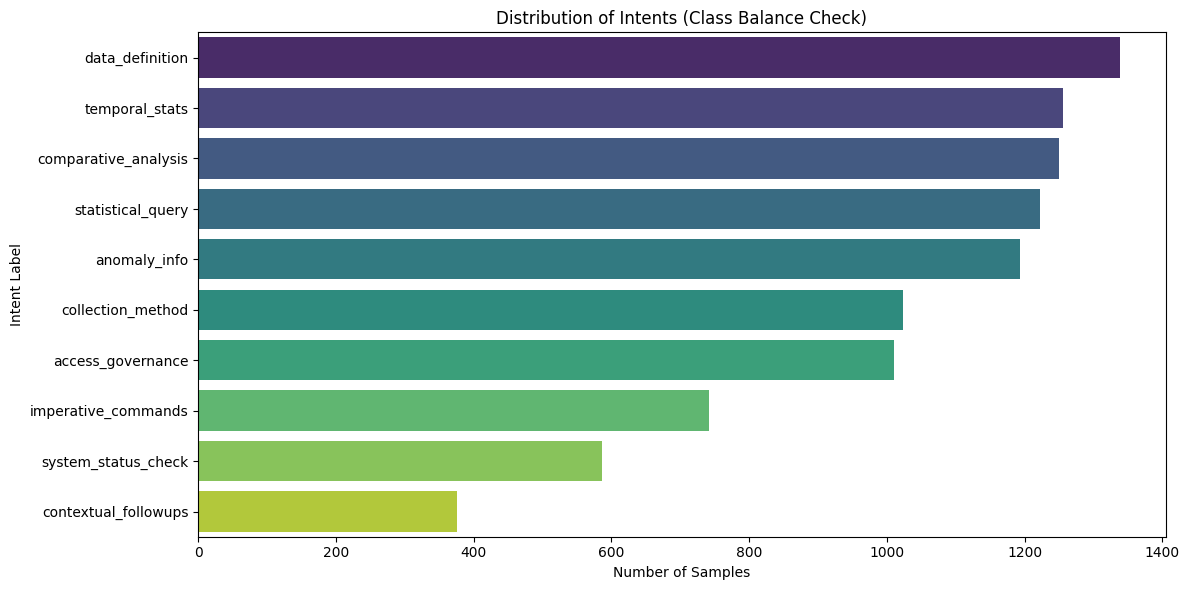

In [23]:
plot_intent_distribution(df)

The Distribution of Intents chart shows a relatively healthy, though slightly "top-heavy" dataset.

- The Lead: data_definition and comparative_analysis are the strongest classes (~1,000 samples each).

- The Weak Link: contextual_followups is significantly underrepresented (~300 samples).

- Risk: The model will likely struggle with conversational continuity. It may default to a more populous intent (like data_definition) when a user asks a vague follow-up question.

- Recommendation: Boost the contextual_followups and system_status_check counts to at least 500–600 to ensure the model doesn't develop a "bias toward definitions."

/tmp/ipython-input-3976837390.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), ax=axes[i], palette='magma')
/tmp/ipython-input-3976837390.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), ax=axes[i], palette='magma')


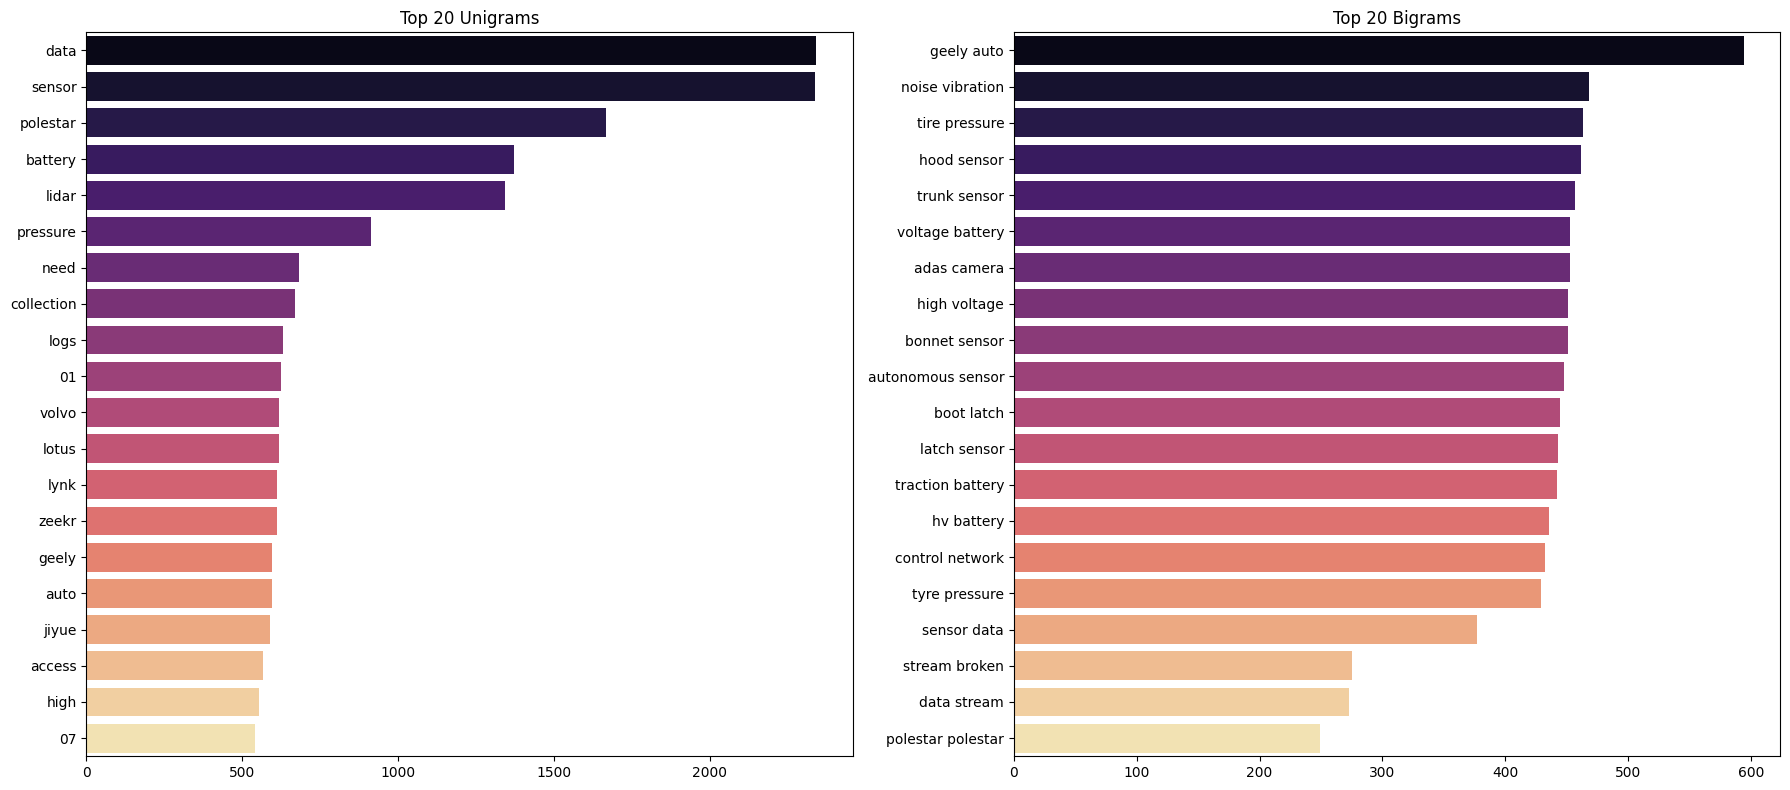

In [24]:
plot_ngram_frequency(df)

The N-Gram analysis confirms that your "Human Error Noise" and regionalisms are present:

- Regional Success: We have both "Tyre Pressure" and "Tire Pressure," as well as "Boot Latch" and "Trunk Sensor." This is excellent for a global UK/US/CN/SE user base.

- The "Geely Auto" Bias: "Geely Auto" is your top bigram.

- Risk: If Geely is over-represented in specific intents (like access_governance), the model might falsely associate the brand name with the intent itself rather than the action.

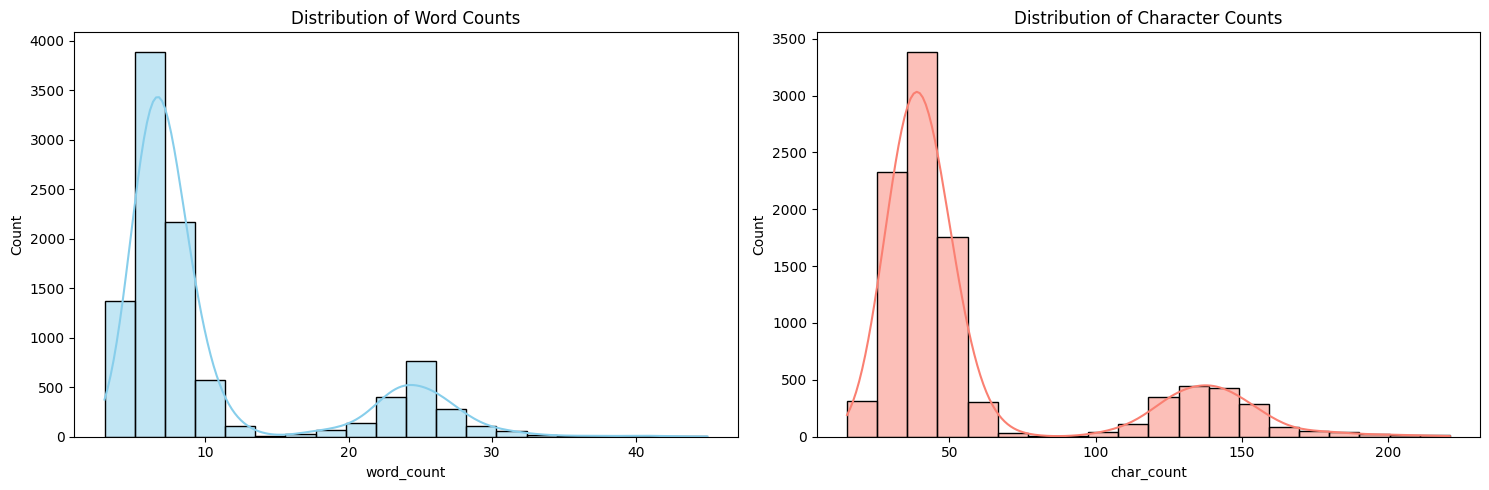

In [25]:
plot_query_complexity(df)

The Distribution of Word Counts shows a tight bell curve peaking at 6–7 words.

- Observation: Most queries are short and punchy ("Show me max HV battery temp").

- Data Hole: There is a "long-tail" deficiency. You have very few queries longer than 12 words.

- Risk: Engineers often "dump" context into a chat ("I am looking at the MDF4 files from the Gothenburg test track from last Tuesday and I see a spike in..."). Your model might not be trained to handle these high-complexity, multi-clause sentences.

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

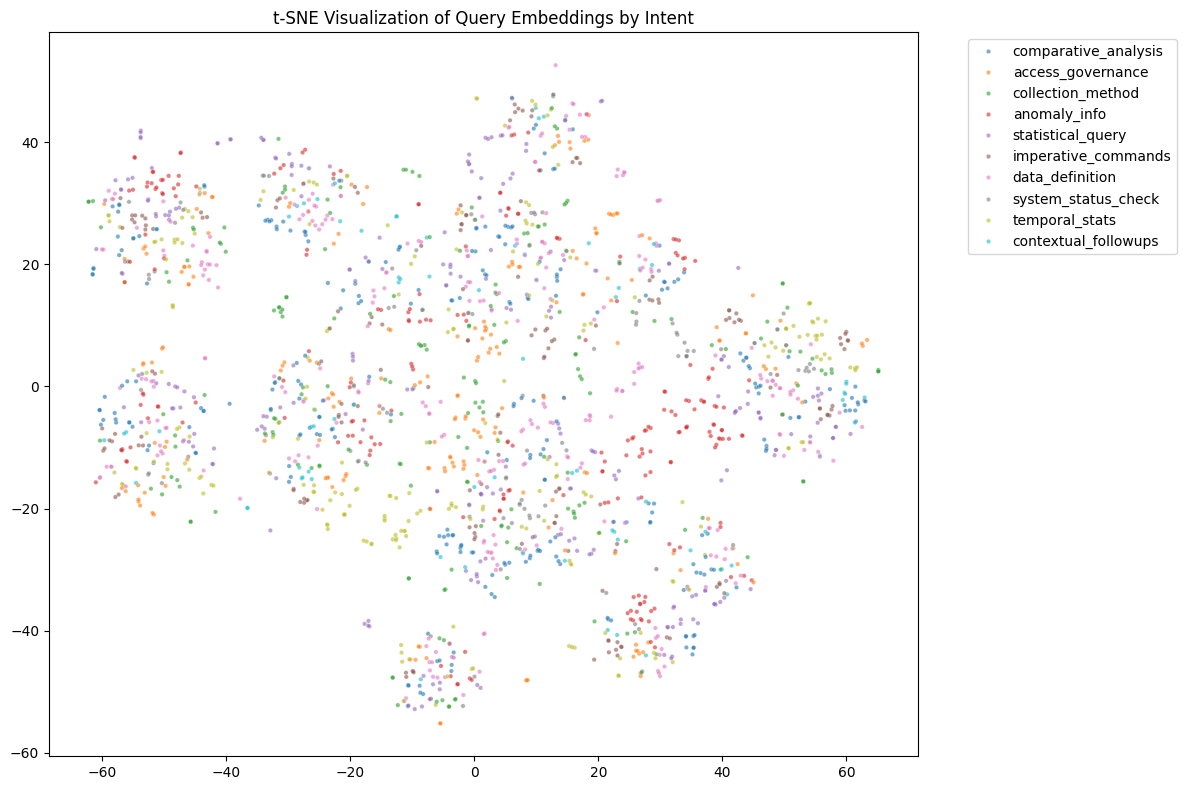

In [26]:
plot_embeddings(df.sample(2000)) # Subsample for faster t-SNE plotting

The t-SNE Embedding graph is the most telling regarding model performance.

- Observation: There is a very high degree of "blending" between clusters. We do not see distinct, isolated "islands" for each intent.

- The "Jargon" Problem: This overlap is likely caused by the technical terms (sensor, battery, HV) appearing across all intents. If a user says "battery sensor data," the model sees the technical nouns clearly but might miss the functional verb that defines the intent.

- Risk: High "Confusion Matrix" scores between statistical_query and anomaly_info. Since both involve numerical analysis of sensors, the model may struggle to distinguish a request for an "average" from a request for an "outlier."

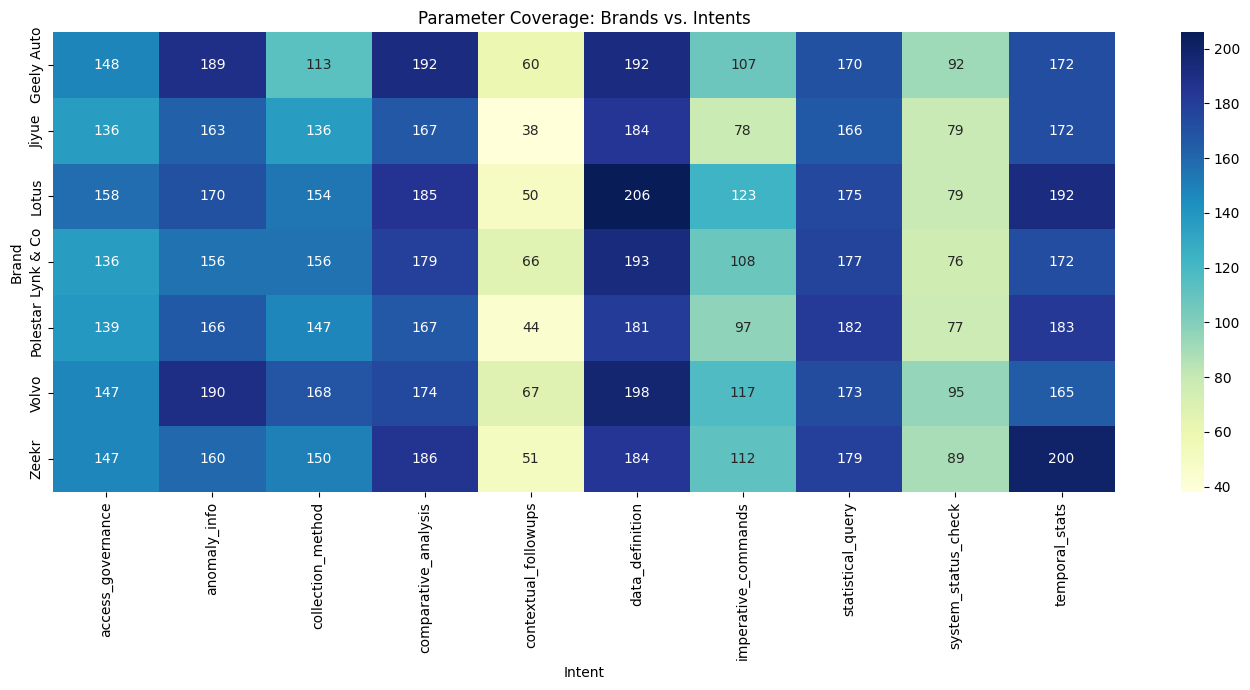

In [27]:
plot_parameter_coverage(df)

The Heatmap shows impressive coverage, but reveals some tactical gaps:

- The Jiyue Gap: In the contextual_followups column, Jiyue has only 29 samples compared to Zeekr's 57.

- The Data Definition Stronghold: Lynk & Co has 168 samples for data_definition, the highest in the set.

- Insight: The model will likely be "smarter" about Lynk & Co sensor definitions than it is about Jiyue ones. This could lead to a localized performance dip for Jiyue engineers.

# Let's Fix the downsides of the above generated data

## Intent Balancer

This function populates the data more to balance out the under-represented intents.

In [28]:
def balance_intents(df, automotive_map, templates, verbose_templates, sensors, tools, formats):
    """Appends rows to reach the frequency of the majority intent."""
    current_counts = df['intent'].value_counts()
    max_count = current_counts.max()
    intent_balancer_run_count = 0
    added_count = 0
    new_rows = []

    print(f"Balancing intents to {max_count} entries each...")

    for intent, count in current_counts.items():
        diff = max_count - count
        if diff <= 0:
            continue

        new_target = len(df)+diff

        with tqdm(total=diff, desc=f'Balancing {intent}...') as pbar:
          while added_count < diff:
            brand, model, year, sensor = select_first_vehicle(list(automotive_map.keys()), None)

            strategy_choice, intent_value, temp = select_query_strategy()

            raw_query = temp.format(
                brand=brand, model=model, year=year, sensor=sensor,
                tool=random.choice(tools), format=random.choice(formats),
                brand_alt=brand, model_alt=model, year_alt=year # Simplified alts
            )

            query = inject_noise_to_query(strategy_choice=strategy_choice, raw_query=raw_query)

            intent_balancer_run_count += 1
            if raw_query not in seen:
              new_rows.append({
                  "query": query,
                  "intent": intent,
                  "brand": brand,
                  "model": model,
                  "year": year,
                  "sensor": sensor,
                  "style": strategy_choice
                  })
              seen.add(raw_query)
              added_count += 1
              pbar.update(1)
    print(f"Ran {intent_balancer_run_count} iterations to balance Intents...")
    return pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)

## Parameter Balancer

This function is meant to balance out the under-represented models so as to avoid localized performance dips

In [29]:
def balance_parameters_by_brand(df, automotive_map, templates, sensors):
    """Ensures every Brand + Intent combination has the same count."""
    # Group by Brand and Intent to find the 'Ideal' count per cell
    brand_intent_balancer_run_count = 0
    counts = df.groupby(['brand', 'intent']).size().unstack(fill_value=0)
    target_per_cell = counts.values.max()
    new_rows = []

    print(f"\n\nBalancing brand coverage to {target_per_cell} entries per intent...")

    for brand in tqdm(automotive_map.keys(), desc='Balancing Brand Coverage...'):
        for intent in templates.keys():
            current_count = len(df[(df['brand'] == brand) & (df['intent'] == intent)])
            diff = target_per_cell - current_count

            while len(new_rows) < target_per_cell:
              _, model, year, sensor = select_first_vehicle([], brand)

              strategy_choice, intent_value, temp = select_query_strategy()

              raw_query = temp.format(
                  brand=brand, model=model, year=year, sensor=sensor,
                  tool="standard rig", format="MDF4",
                  brand_alt=brand, model_alt=model, year_alt=year
              )

              query = inject_noise_to_query(strategy_choice=strategy_choice, raw_query=raw_query)

              brand_intent_balancer_run_count += 1
              if raw_query not in seen:
                new_rows.append({
                    "query": query,
                    "intent": intent,
                    "brand": brand,
                    "model": model,
                    "year": year,
                    "sensor": sensor,
                    "style": strategy_choice
                    })
                seen.add(raw_query)
    print(f"Ran {brand_intent_balancer_run_count} iterations to balance Parameters by Brand...")
    return pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)

## Run the Fixer-Uppers

In [30]:
# Step 1: Fix intent under-representation
before_len = len(df)
df = balance_intents(df, AUTOMOTIVE_MAP, TEMPLATES, VERBOSE_TEMPLATES, SENSORS, SPECIAL_TOOLS, FORMATS)
print(f"{len(df)-before_len} New entries appended...")
print(f"Current Entry Count : {len(df)}")

Balancing intents to 1338 entries each...


Balancing contextual_followups...:  22%|██▏       | 211/962 [00:00<00:00, 35616.47it/s]

Ran 1979 iterations to balance Intents...
962 New entries appended...
Current Entry Count : 10962


Final Intent Distribution: 
intent
data_definition         1338
temporal_stats          1338
comparative_analysis    1256
statistical_query       1250
anomaly_info            1222
collection_method       1194
access_governance       1024
imperative_commands     1011
system_status_check      742
contextual_followups     587
Name: count, dtype: int64




/tmp/ipython-input-354434878.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='intent', order=df['intent'].value_counts().index, palette='viridis')


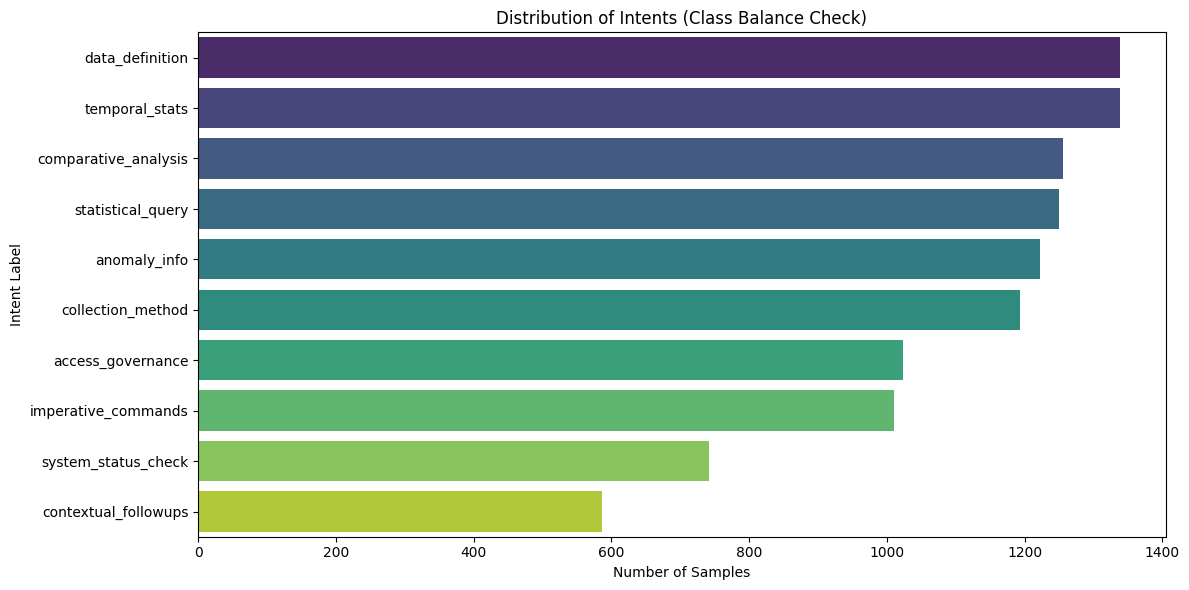

In [31]:
# Final check
print(f"Final Intent Distribution: \n{df['intent'].value_counts()}\n\n")

plot_intent_distribution(df)

In [32]:
# Step 2: Fix brand-specific gaps (Focus on Brand Parameter)
before_count = len(df)
df = balance_parameters_by_brand(df, AUTOMOTIVE_MAP, TEMPLATES, SENSORS)
print(f"{len(df)-before_len} New entries appended...")
print(f"Current Entry Count : {len(df)}")



Balancing brand coverage to 216 entries per intent...


Balancing Brand Coverage...: 100%|██████████| 7/7 [00:00<00:00, 34.29it/s]

Ran 408 iterations to balance Parameters by Brand...
1178 New entries appended...
Current Entry Count : 11178



Final Brand Distribution: 
brand
Volvo         1841
Zeekr         1623
Lotus         1620
Geely Auto    1577
Lynk & Co     1557
Polestar      1521
Jiyue         1439
Name: count, dtype: int64




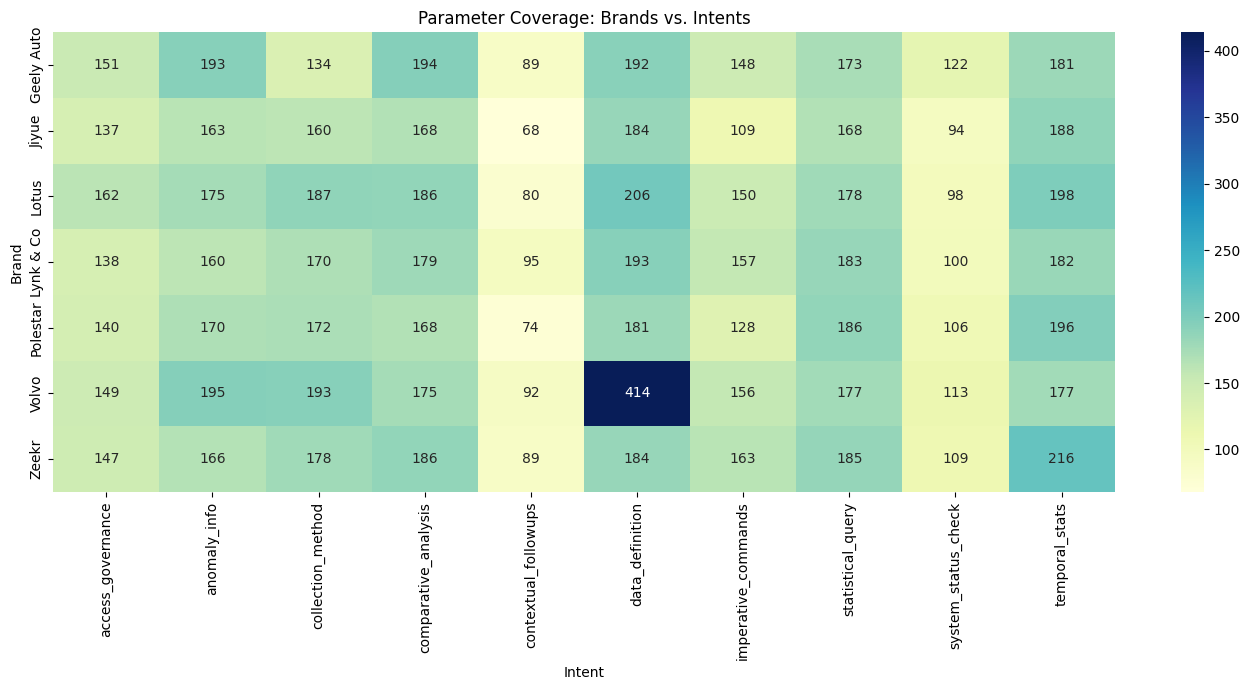

In [33]:
print(f"\nFinal Brand Distribution: \n{df['brand'].value_counts()}\n\n")

plot_parameter_coverage(df)

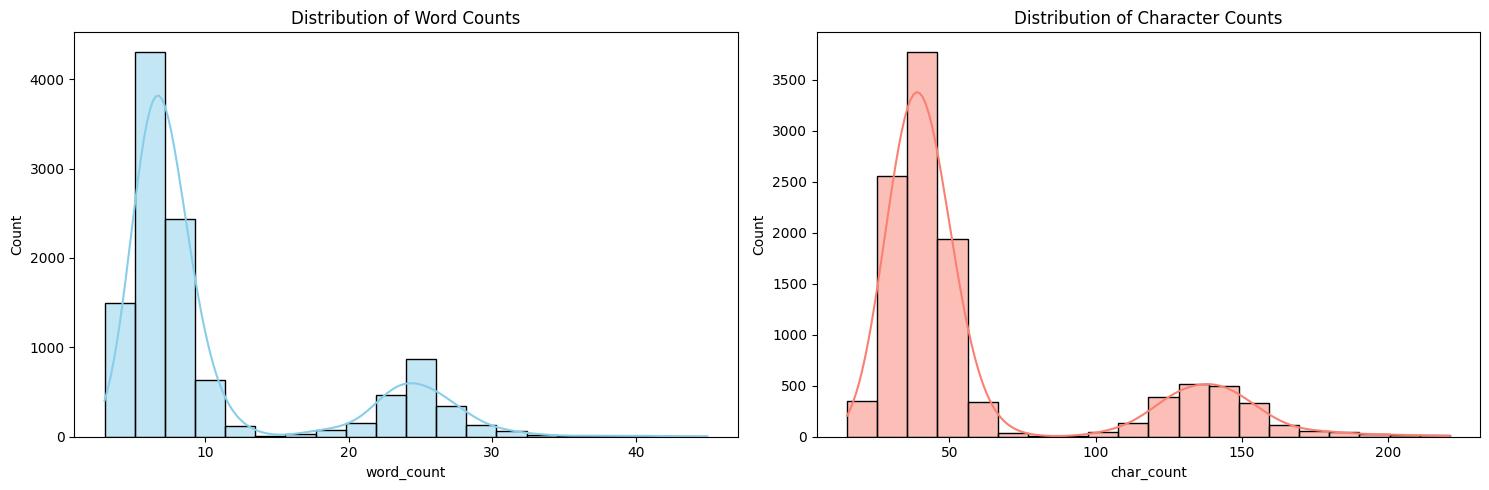

In [34]:
plot_query_complexity(df)

# Let's Finally save this generated data

In [35]:
print(f"Success! Currently df contains {len(df)} unique entries for automotive sensor intent model.")

Success! Currently df contains 11178 unique entries for automotive sensor intent model.


In [36]:
df.to_csv("intent_dataset.csv", index=False)